In [47]:
# segment and denoise audio from time stamps, scroll down to 'user input begins here' to use
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import soundfile as sf
import noisereduce as nr
from scipy.signal import firwin, filtfilt,lfilter,butter


In [48]:
def find_csv_file(directory):
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            return os.path.join(directory, file)
    return None

def load_metadata(csv_path):
    return pd.read_csv(csv_path)

def create_directory_structure(base_path):
    """
    Create the following folder structure:
    base_path/
        |---segmented_audio
            |---raw
            |---bandpass
            |---denoised
    """
    subfolders = ['segmented_audio']
    subsubfolders = ['raw', 'bandpass', 'denoised']
    
    for subfolder in subfolders:
        for subsubfolder in subsubfolders:
            folder_path = os.path.join(base_path, subfolder, subsubfolder)
            os.makedirs(folder_path, exist_ok=True)
            print(f"Created directory: {folder_path}")

def fir_bandpass_filter(data, lowcut, highcut, fs, numtaps=2048, window='hamming'):
    nyquist = 0.5 * fs
    low = (lowcut) / nyquist
    high = (highcut) / nyquist
    b = firwin(numtaps, [low, high], pass_zero=False, window=window)
    y = filtfilt(b, 1.0, data)
    return y

def highpass_filter(data, cutoff_freq, fs, order=5):
    nyquist = 0.5 * fs
    cutoff = cutoff_freq / nyquist
    b, a = butter(order, cutoff, btype='high', analog=False, output='ba')
    y = filtfilt(b, a, data)
    return y

def noisereduce_wav(y, sr):
    epsilon = 1e-10
    y = nr.reduce_noise(y=y+epsilon,stationary=False, sr=sr,n_fft=2048,
                        prop_decrease=0.99,
                        win_length=2048,
                        hop_length=512,
                        time_mask_smooth_ms=50,
                        freq_mask_smooth_hz=50,
                        n_jobs=-1)
    return y

def normalize_amplitude(original, processed):
    original_rms = np.sqrt(np.mean(original**2))
    processed_rms = np.sqrt(np.mean(processed**2))
    if processed_rms == 0:  # Avoid division by zero
        return processed
    gain = original_rms / processed_rms
    return processed * gain

def match_target_amplitude(y, target_dBFS=-20):
    rms = (y ** 2).mean() ** 0.5
    scalar = 10 ** (target_dBFS / 20) / (rms + 1e-9)
    return y * scalar

def apply_fade(audio, sr, fade_duration=0.1):
    fade_samples = int(fade_duration * sr)
    fade_in = np.linspace(0, 1, fade_samples)
    fade_out = np.linspace(1, 0, fade_samples)

    audio[:fade_samples] *= fade_in
    audio[-fade_samples:] *= fade_out

    return audio


def pad_audio_with_clipping(audio, target_duration, sample_rate, original_audio, start_idx, end_idx):
    """
    Pad the audio with clipping from just before and after the segment.

    Args:
    audio (np.array): The audio data to pad.
    target_duration (float): The desired duration in seconds.
    sample_rate (int): The sample rate of the audio.
    original_audio (np.array): The original audio data to use for padding.
    start_idx (int): The start index of the segment in the original audio.
    end_idx (int): The end index of the segment in the original audio.

    Returns:
    np.array: The padded audio data.
    """
    current_samples = len(audio)
    target_samples = int(target_duration * sample_rate)
    
    if current_samples < target_samples:
        pad_length = target_samples - current_samples
        pad_left = original_audio[max(0, start_idx - pad_length // 2):start_idx]
        pad_right = original_audio[end_idx:min(len(original_audio), end_idx + pad_length - len(pad_left))]
        
        # If not enough padding on either side, use remaining padding from the other side
        if len(pad_left) + len(pad_right) < pad_length:
            if len(pad_left) < pad_length // 2:
                pad_right = original_audio[end_idx:end_idx + pad_length - len(pad_left)]
            if len(pad_right) < pad_length // 2:
                pad_left = original_audio[start_idx - pad_length + len(pad_right):start_idx]
        
        padded_audio = np.concatenate([pad_left, audio, pad_right])
        #print(f"Padding audio from {current_samples} to {target_samples} samples")
        return padded_audio
    else:
        return audio[:target_samples]  # Truncate if longer than target duration

def process_and_segment_audio(audio, sr, df_file, output_base_path, fmin, fmax, segment_length=2.0):
    """
    Process and segment audio files based on metadata from a CSV file.
    
    Args:
    audio (np.array): The audio data.
    sr (int): The sample rate of the audio.
    df_file (pd.DataFrame): DataFrame containing metadata for the audio file.
    output_base_path (str): Base path for output directories.
    segment_length (float): Length of each segment in seconds.
    overlap_percent (float): Percentage of overlap between adjacent segments.
    """
    #print("Applying band-pass filter...")
    # filtered_audio = highpass_filter(audio, 150, sr)
    filtered_audio = fir_bandpass_filter(audio, fmin, fmax, sr)
    
    filtered_audio = match_target_amplitude(filtered_audio)
    
    #print("Applying noise reduction to entire audio...")
    denoised_audio = noisereduce_wav(filtered_audio, sr)
    
    denoised_audio = match_target_amplitude(denoised_audio)
    
    raw_dir = os.path.join(output_base_path, 'segmented_audio', 'raw')
    bandpass_dir = os.path.join(output_base_path, 'segmented_audio', 'bandpass')
    denoised_dir = os.path.join(output_base_path, 'segmented_audio', 'denoised')
    
    for _, row in df_file.iterrows():
        start_time = round(row['start_time'], 2)
        end_time = round(row['end_time'], 2)
        species = row['species'].replace(" ", "_")
        duration = end_time - start_time
        
        #print(f"Processing segment for {species} from {start_time} to {end_time}")
        
        if duration <= segment_length:
            # For segments shorter than or equal to 1.5 seconds
            segment_starts = [
                start_time,
                # max(round(start_time - (segment_length - overlap_percent * segment_length), 2), 0),
                # min(round(start_time + (segment_length - overlap_percent * segment_length), 2), len(audio) / sr - segment_length)
            ]
            # segment_ends = [segment_starts[0] + duration, segment_starts[1] + duration ,min(segment_starts[2] + duration, end_time)]
            segment_ends = [segment_starts[0] + duration]   
        else:
            # For segments longer than 1.5 seconds
            segment_starts = []
            current_start = start_time
            while current_start < end_time:
                segment_starts.extend([
                    # max(round(current_start - (segment_length - overlap_percent * segment_length), 2), 0),
                    current_start,
                    # min(round(current_start + (segment_length - overlap_percent * segment_length), 2), len(audio) / sr - segment_length)
                ])
                current_start += segment_length  # Move by segment_length each time
            
            # Remove duplicates and sort
            segment_starts = sorted(set(segment_starts))
            segment_ends = [min(start + segment_length, end_time) for start in segment_starts]

            # Remove the last segment if it's shorter than segment_length
            if segment_ends[-1] - segment_starts[-1] < segment_length:
                segment_starts.pop()
                segment_ends.pop()
        
        for seg_start, seg_end in zip(segment_starts, segment_ends):
            #print(f"  Extracting segment from {seg_start} to {seg_end}")
            
            # Extract segments
            start_idx = int(seg_start * sr)
            end_idx = int(seg_end * sr)
            original_segment = audio[start_idx:end_idx]
            bandpass_segment = filtered_audio[start_idx:end_idx]
            denoised_segment = denoised_audio[start_idx:end_idx]
            
            # Pad segments if necessary
            original_segment = pad_audio_with_clipping(original_segment, segment_length, sr, audio, start_idx, end_idx)
            bandpass_segment = pad_audio_with_clipping(bandpass_segment, segment_length, sr, filtered_audio, start_idx, end_idx)
            denoised_segment = pad_audio_with_clipping(denoised_segment, segment_length, sr, denoised_audio, start_idx, end_idx)
            
            # Save raw segment
            save_segment(original_segment, sr, row['filename'], seg_start, seg_end, species, raw_dir)
            save_segment(bandpass_segment, sr, row['filename'], seg_start, seg_end, species, bandpass_dir)
            save_segment(denoised_segment, sr, row['filename'], seg_start, seg_end, species, denoised_dir)
            
            #print(f"  Saved raw and denoised segments")

def save_segment(segment, sr, original_filename, start, end, species, output_dir):
    species_dir = os.path.join(output_dir, species)
    os.makedirs(species_dir, exist_ok=True)
    
    segment_filename = os.path.join(species_dir, f"{os.path.splitext(original_filename)[0]}_{int(start*1000)}_{int(end*1000)}.wav")
    sf.write(segment_filename, segment, sr)
    #print(f"Saved segment: {segment_filename}")

def process_all_audio_files(df, base_audio_path, output_base_path, fmin=150, fmax=650, segment_length=2.0):
    grouped = df.groupby('filename')
    
    for filename, group_df in grouped:
        input_path = os.path.join(base_audio_path, filename)
        if os.path.exists(input_path):
            #print(f"Processing file: {input_path}")
            audio, sr = librosa.load(input_path)
            process_and_segment_audio(audio, sr, group_df, output_base_path, fmin = fmin, fmax=fmax, segment_length=segment_length)
        else:
            print(f"File not found: {input_path}")

## USER INPUT BEGINS HERE!

In [59]:
# Define the directory containing the raw audio files
base_dir = "/home/leah_colossal_com/us_bird_data"

species = ['white_throated_sparrow','northern_cardinal','carolina_wren','eastern_towhee','kentucky_warbler','kentucky_warbler_test']
species_idx = 5
raw_dir = "/home/leah_colossal_com/us_bird_data/{}/raw/".format(species[species_idx])
processed_dir = "/home/leah_colossal_com/us_bird_data/{}/processed/".format(species[species_idx])
species_label = species[species_idx]

# define the bandpass filters that should be used for each species, this helps with denoising, but you can also just set to max limits 
bp_filters = {'white_throated_sparrow':[1,8192],
              'northern_cardinal':[1,8192],
              'carolina_wren':[1,8192],
              'eastern_towhee':[1,8192],
              'kentucky_warbler':[1,8192]
             }

# test set kentucky warbler should have the same bp filter as train
bp_filters['kentucky_warbler_test'] = bp_filters['kentucky_warbler']

# get bandpass limits for this particular species
bandpass_lower_limit = bp_filters[species_label][0]
bandpass_upper_limit = bp_filters[species_label][1]

In [60]:
# Example usage
metadata_directory = raw_dir
base_audio_path = raw_dir  # Directory where the .wav files are located
csv_file_path = find_csv_file(metadata_directory)
create_directory_structure(processed_dir)
segmented_output_path = os.path.join(processed_dir,'segmented_audio')

if csv_file_path:
    #print(f"Found CSV file: {csv_file_path}")
    metadata_df = load_metadata(csv_file_path)
    if metadata_df is not None:
        process_all_audio_files(metadata_df, base_audio_path, processed_dir,
                        fmin = bandpass_lower_limit,fmax = bandpass_upper_limit)

Created directory: /home/leah_colossal_com/us_bird_data/kentucky_warbler_test/processed/segmented_audio/raw
Created directory: /home/leah_colossal_com/us_bird_data/kentucky_warbler_test/processed/segmented_audio/bandpass
Created directory: /home/leah_colossal_com/us_bird_data/kentucky_warbler_test/processed/segmented_audio/denoised


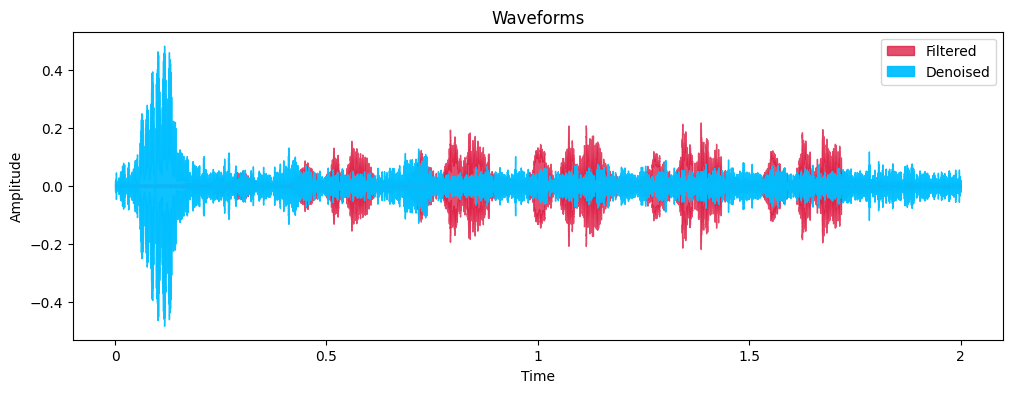

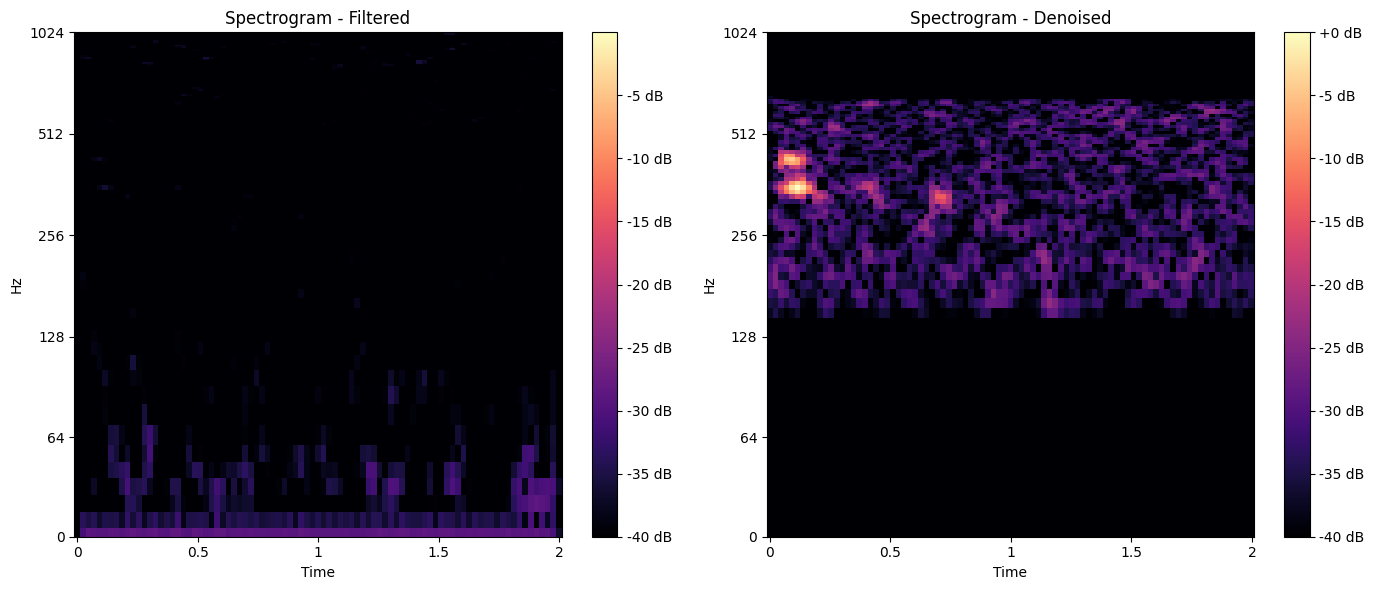

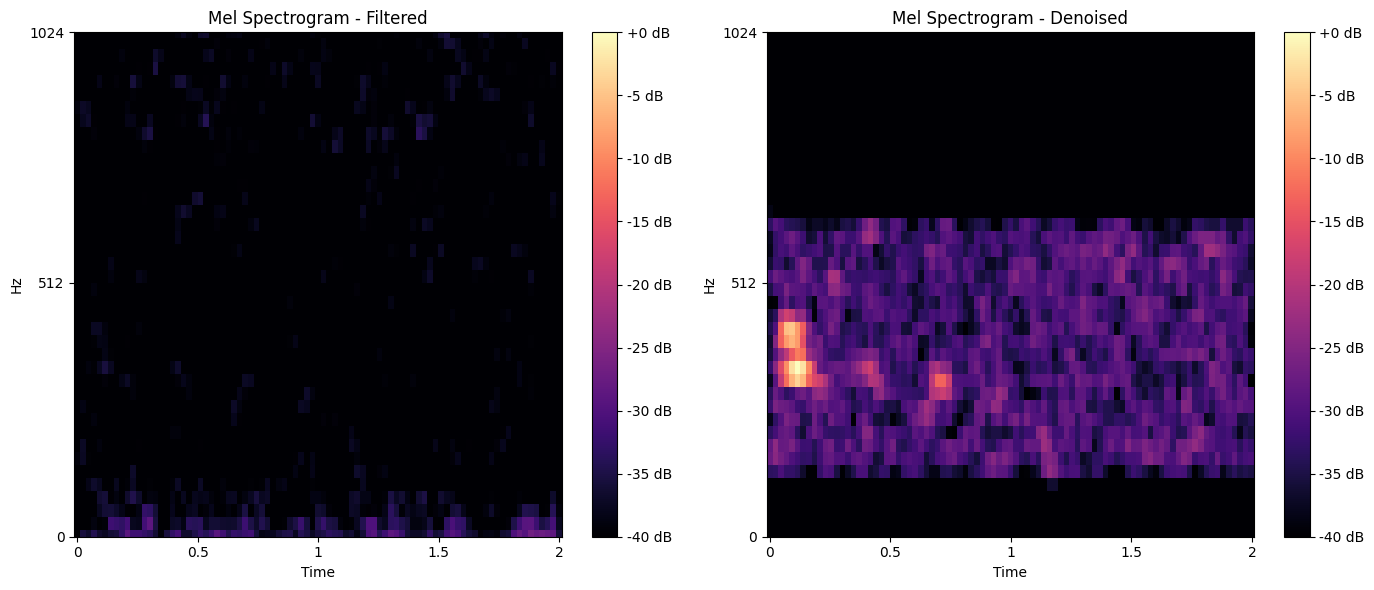

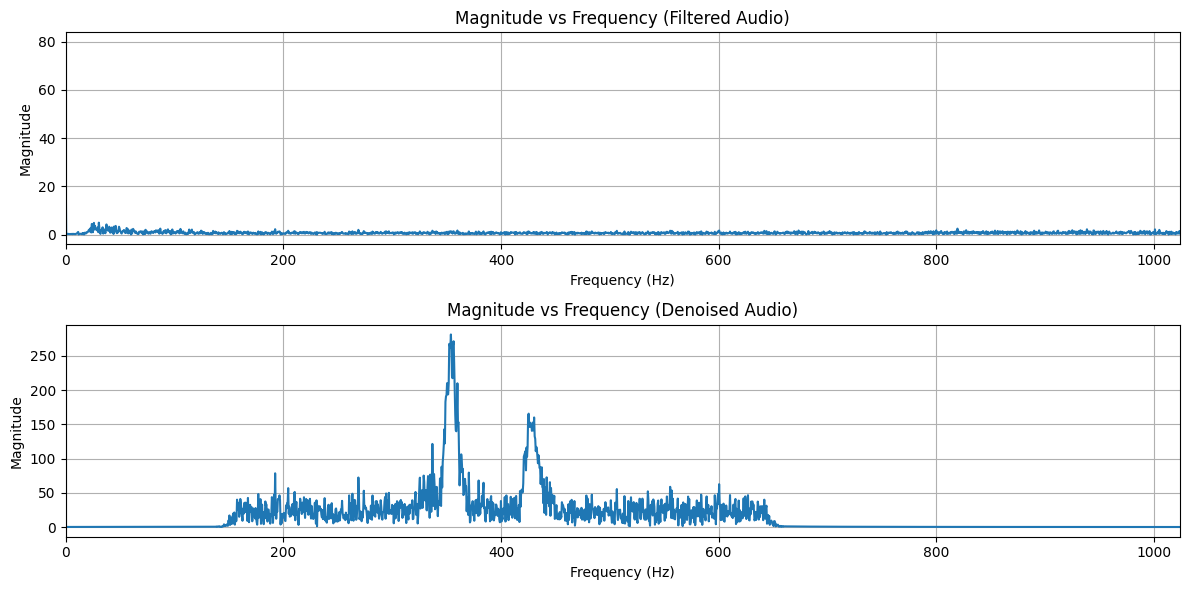

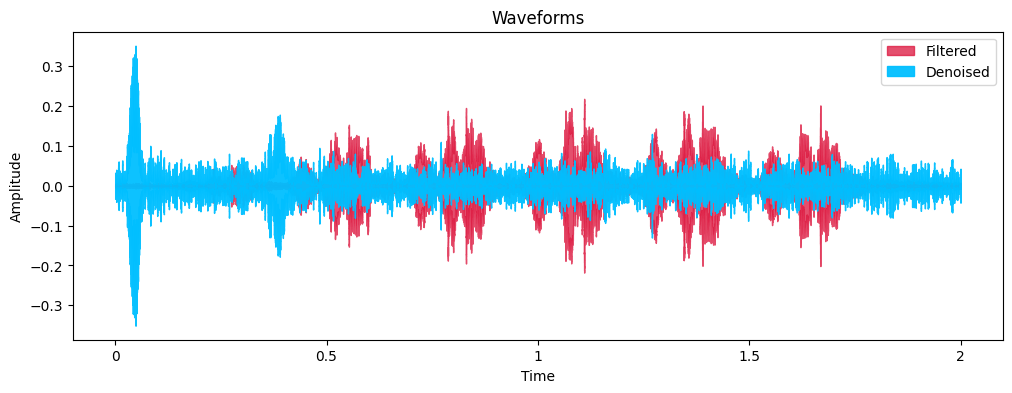

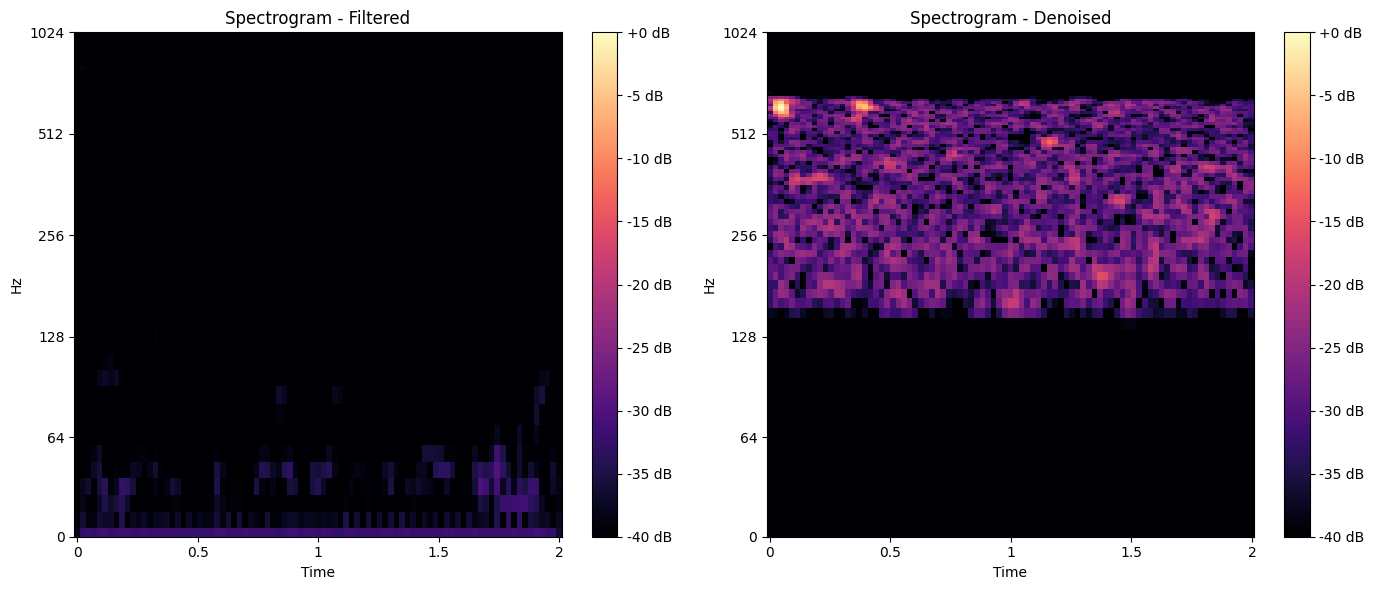

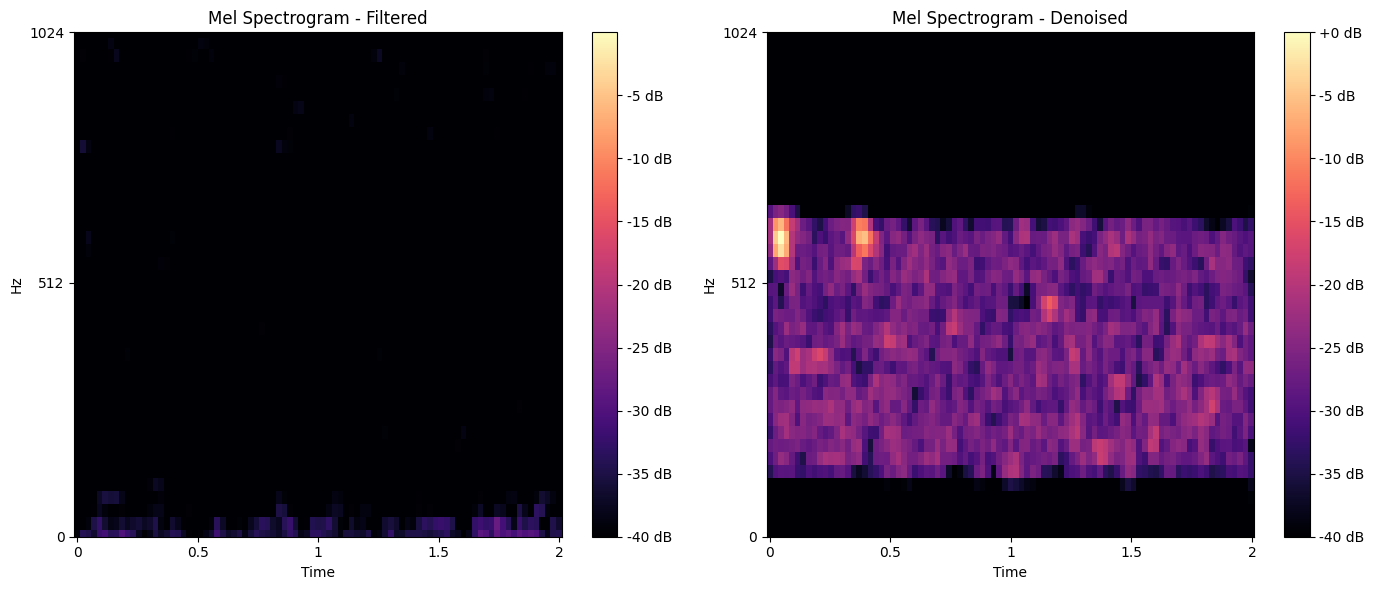

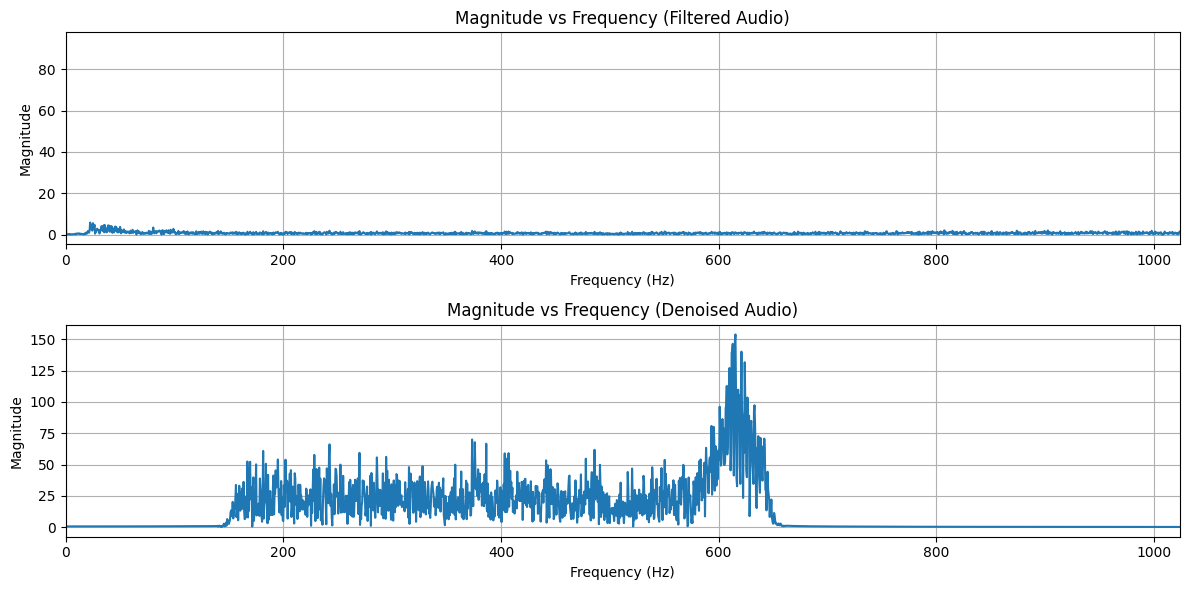

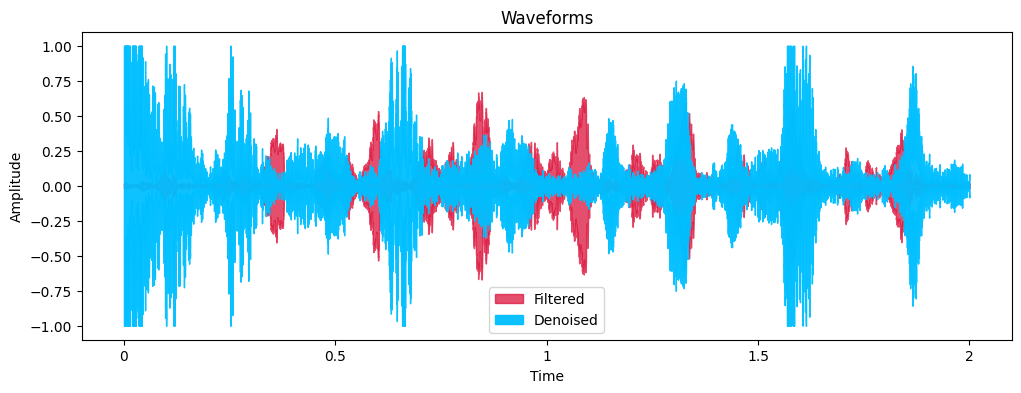

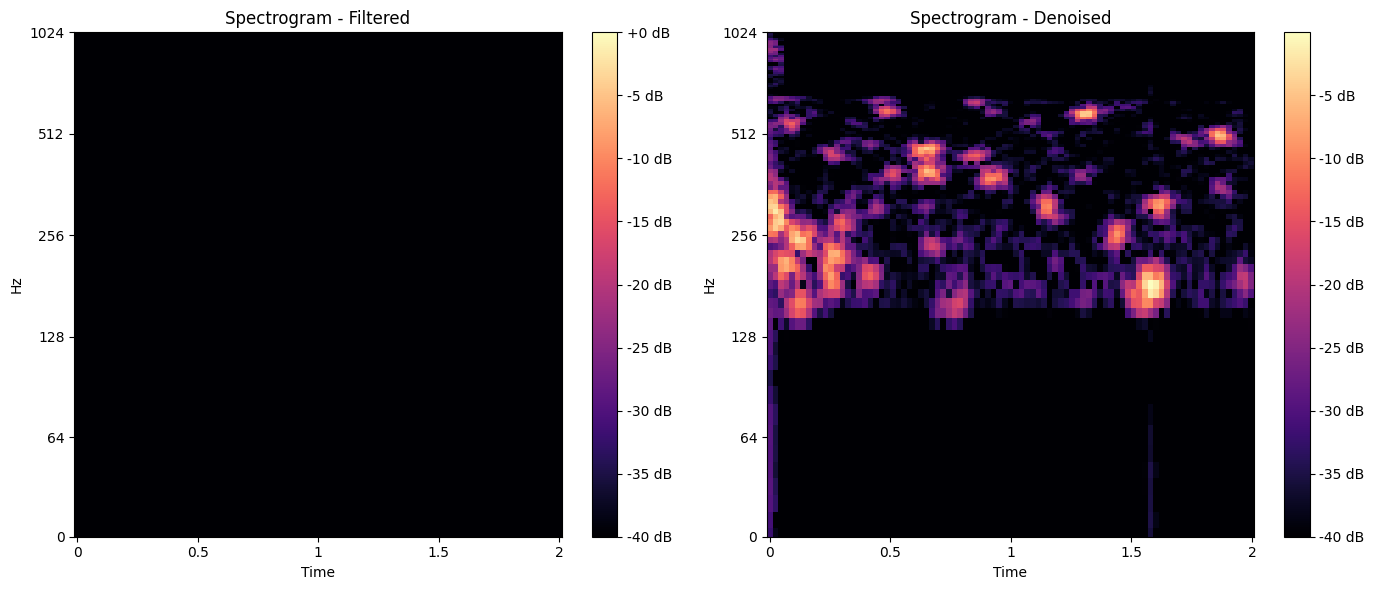

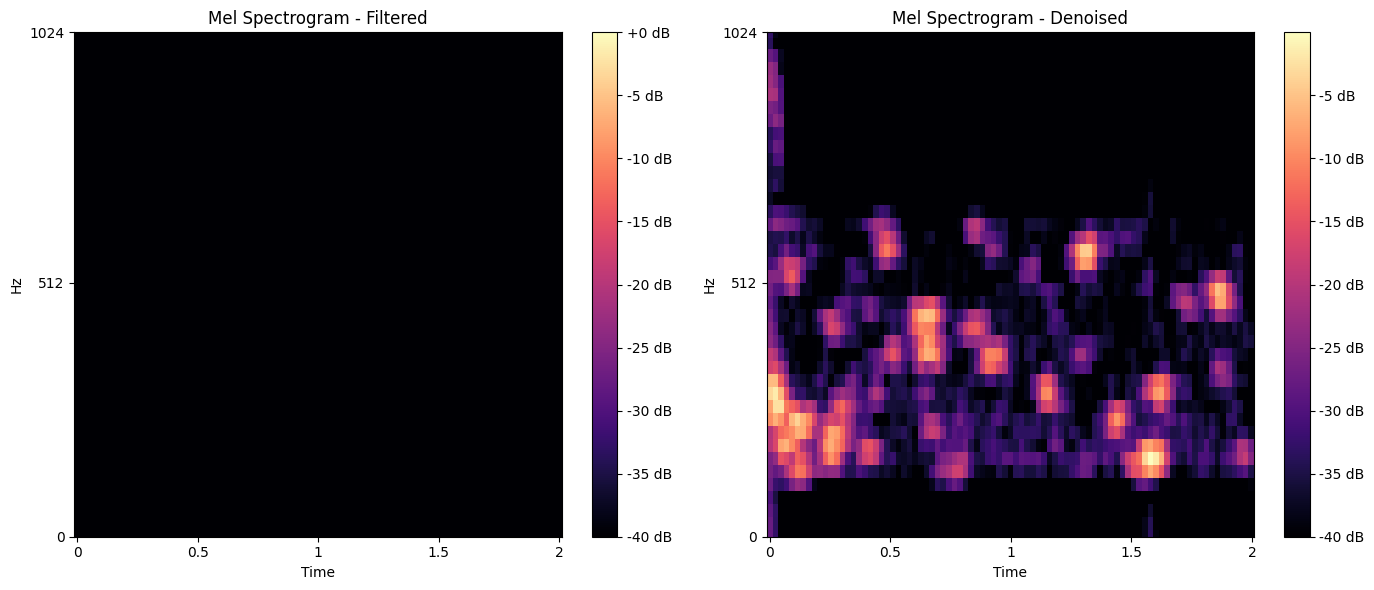

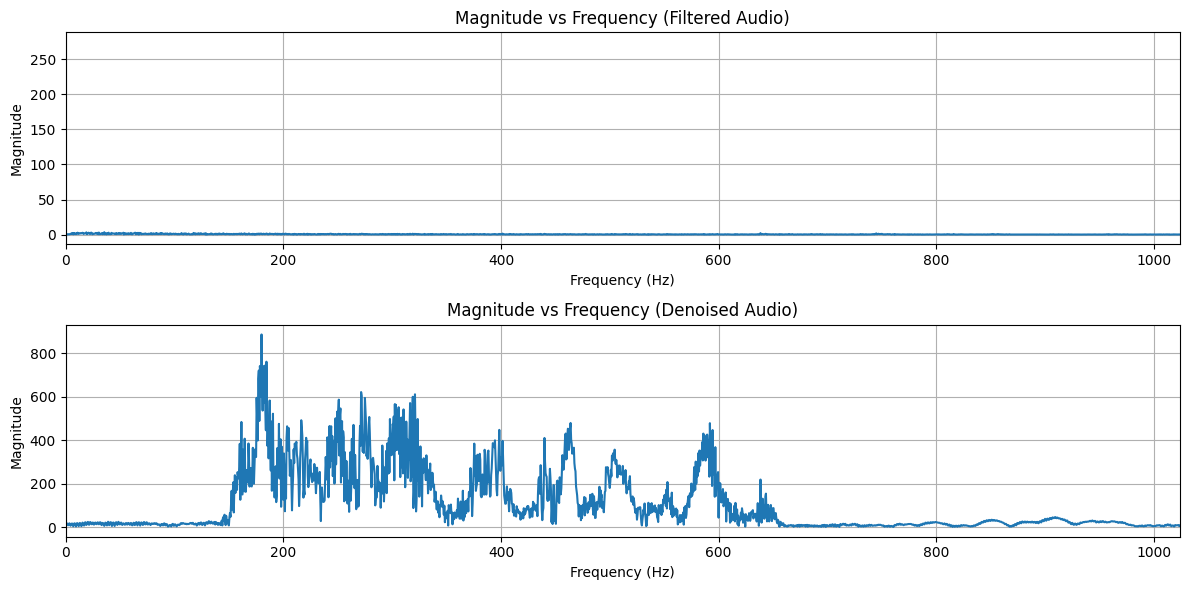

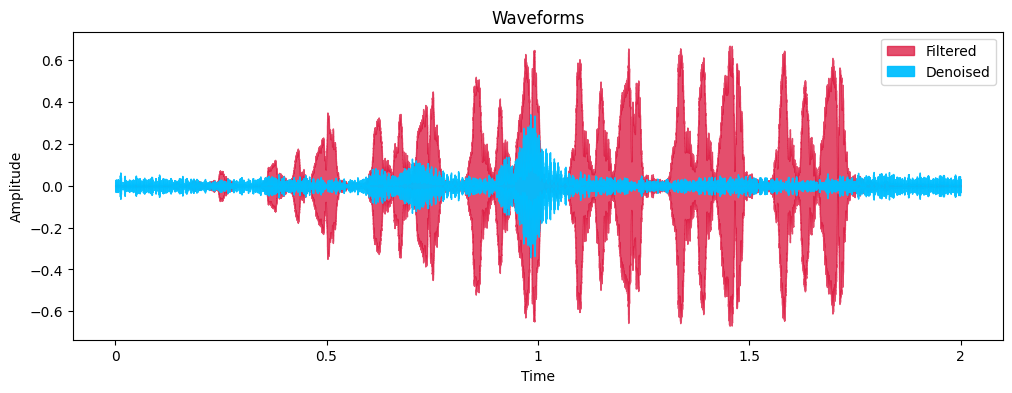

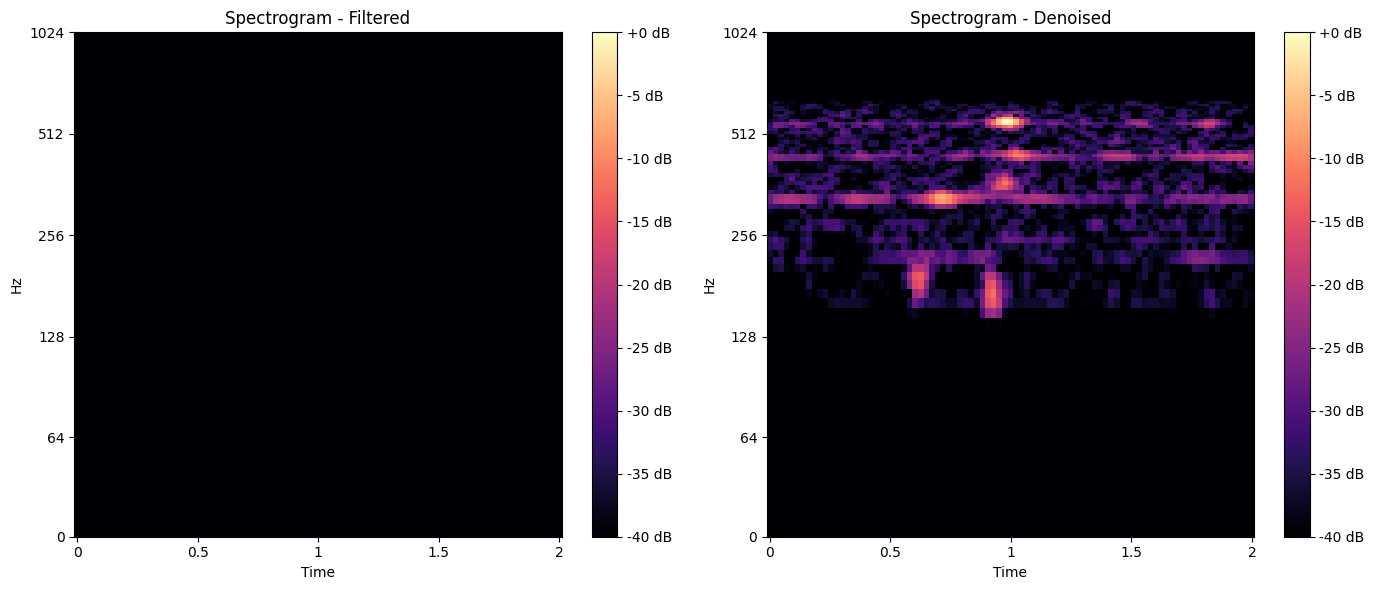

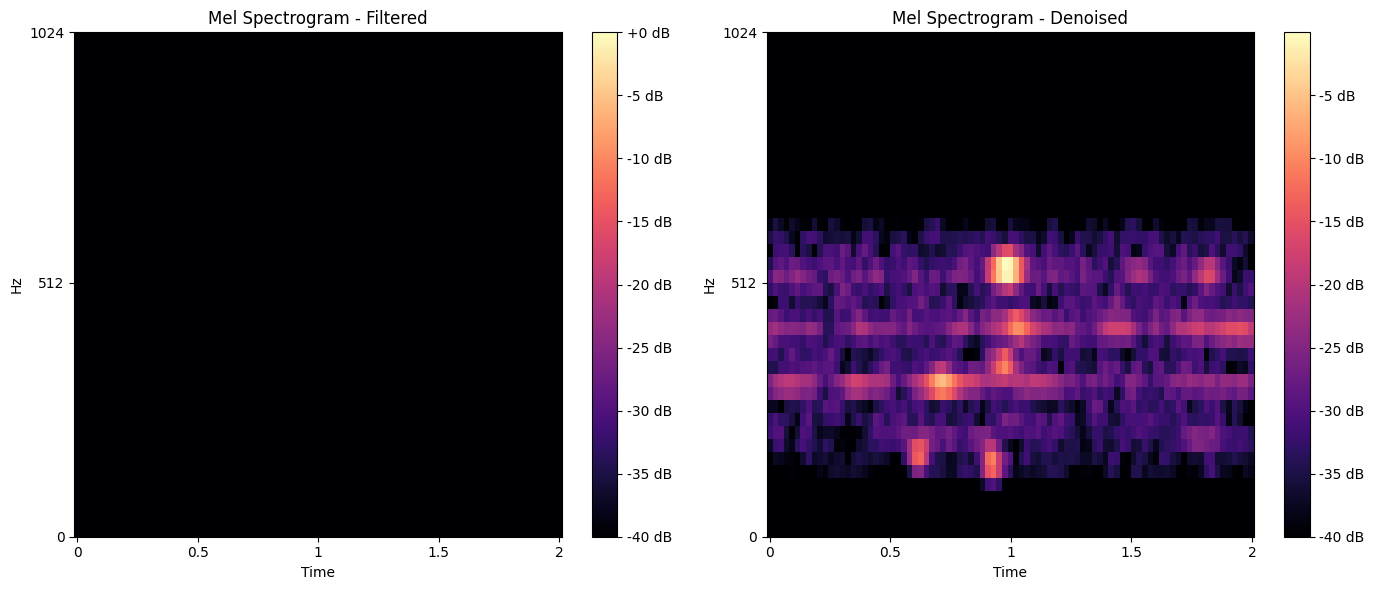

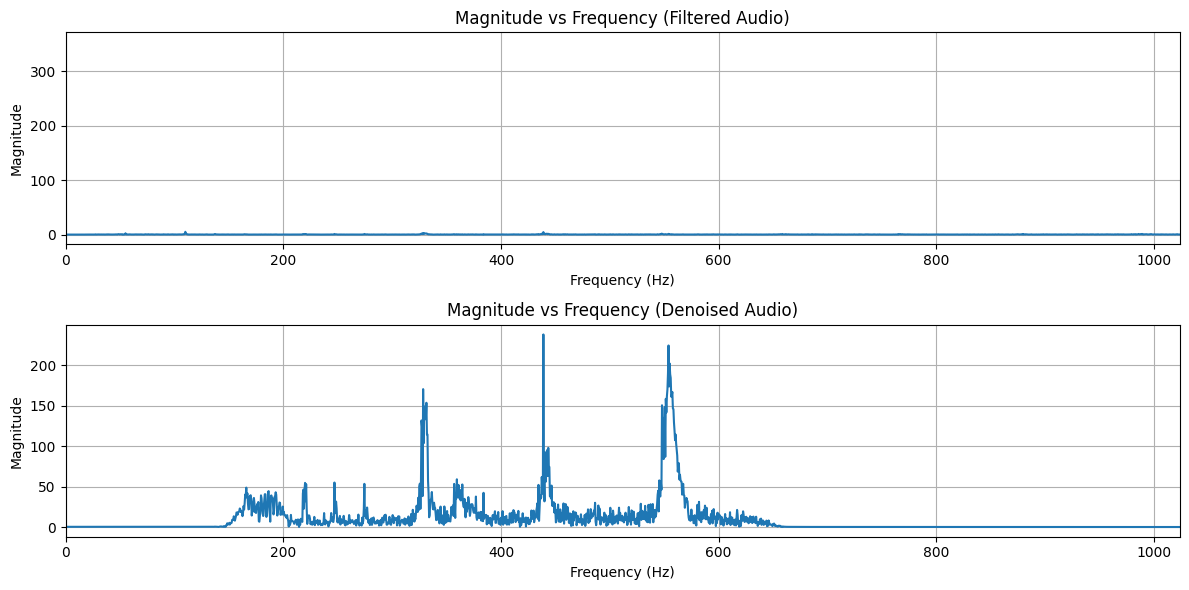

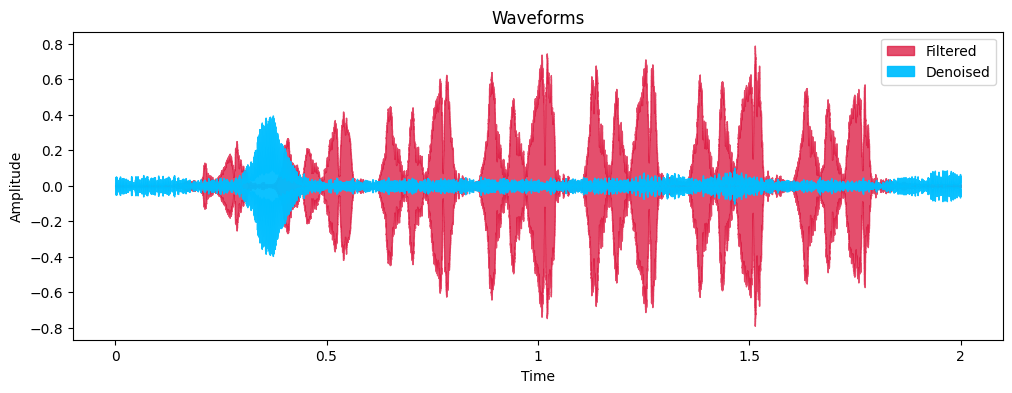

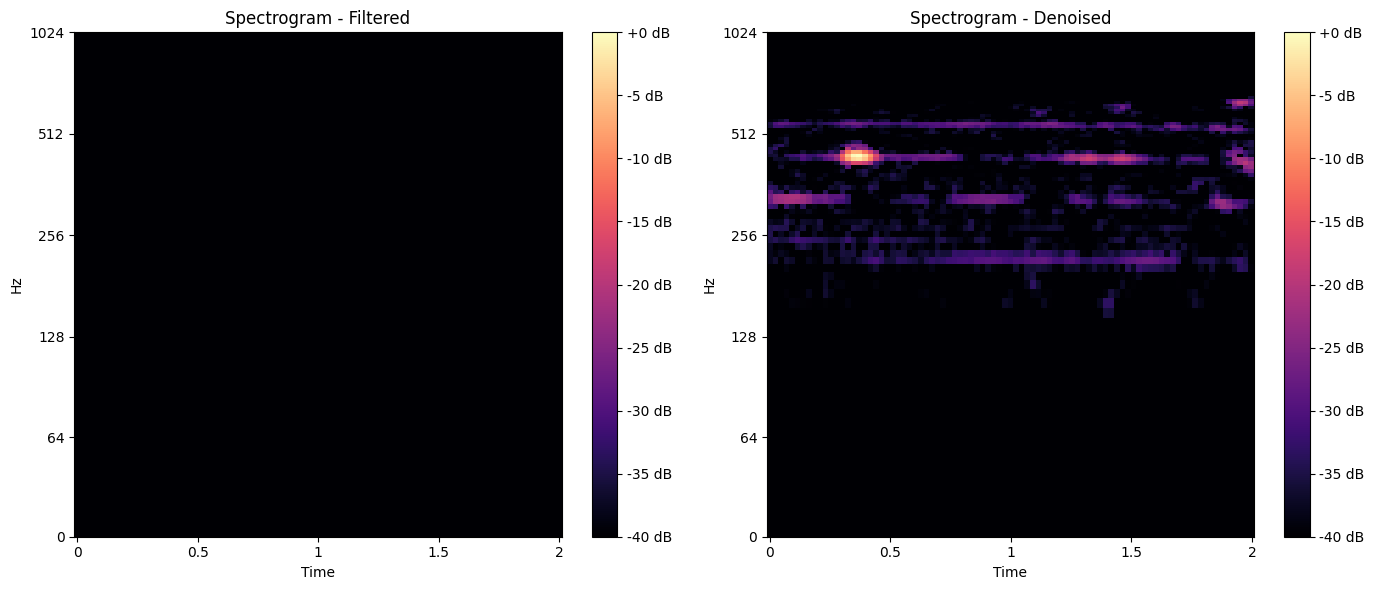

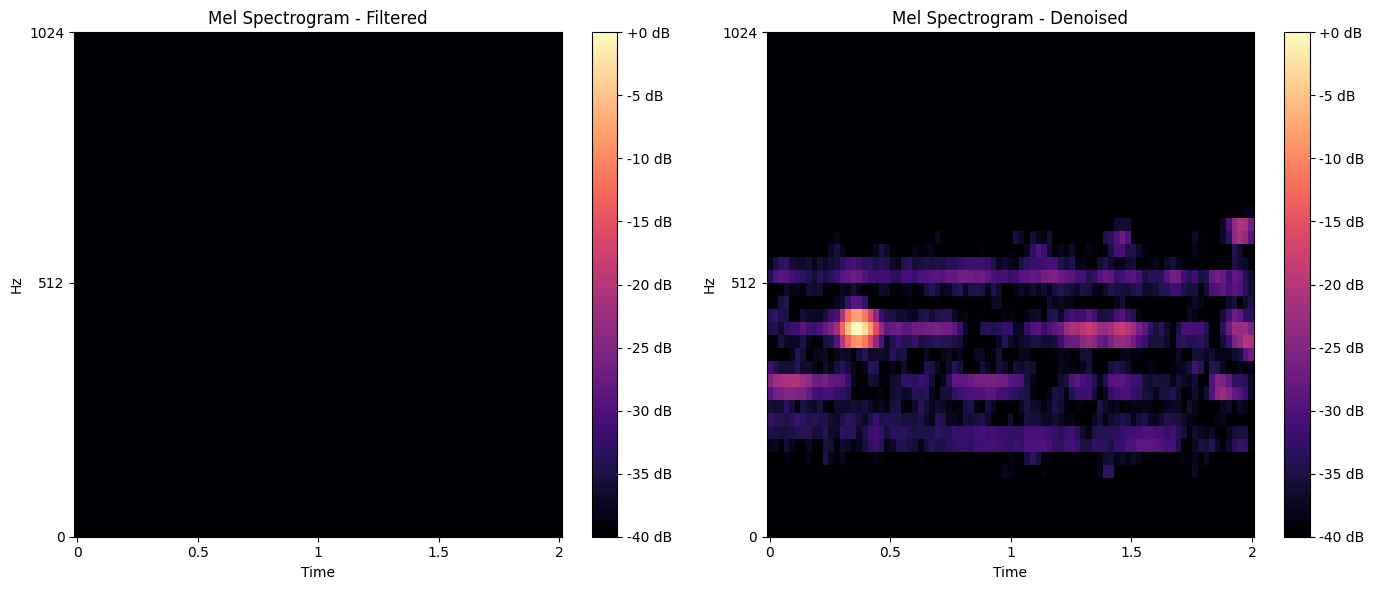

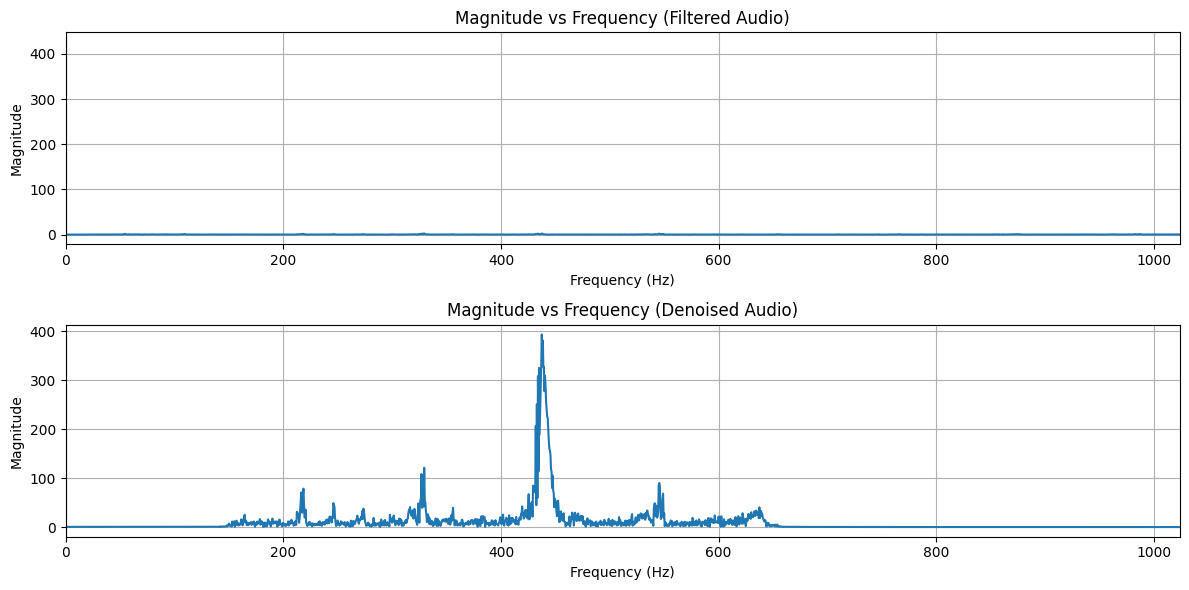

In [22]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import noisereduce as nr

def display_audio_and_waveforms(audio_list, sr, show_audio=True):
    """
    Display audio files and their waveforms.
    
    Parameters:
    audio_list (list): List of tuples (audio_array, label).
    sr (int): Sample rate.
    show_audio (bool): Whether to display the audio players.
    """
    # Plot waveforms
    plt.figure(figsize=(12, 4))
    colors = ['crimson', 'deepskyblue' ,'r', 'c', 'm', 'y', 'k']
    
    for i, (audio_data, label) in enumerate(audio_list):
        if show_audio:
            display(Audio(audio_data, rate=sr, autoplay=False))
        
        color = colors[i % len(colors)]
        alpha = 0.75 if i < len(audio_list) - 1 else 0.95
        librosa.display.waveshow(audio_data, sr=sr, alpha=alpha, color=color, label=label)
    
    plt.title('Waveforms')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

def display_spectrogram(audio_list,sr):
    """
    Display the spectrogram of the audio files.
    
    Parameters:
    audio_list (list): List of tuples (audio_array, label).
    sr (int): Sample rate.
    """
    plt.figure(figsize=(14, 6))
    threshold = -40
    for i, (audio_data, label) in enumerate(audio_list):
        plt.subplot(1,len(audio_list), i + 1)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
        D[D<threshold] = threshold
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', label=label)
        plt.ylim([0, 1024])
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Spectrogram - {label}')
    plt.tight_layout()
    plt.show()

def display_mel_spectrogram(audio_list, sr):
    """
    Display the mel spectrogram of the audio files side by side.
    
    Parameters:
    audio_list (list): List of tuples (audio_array, label).
    sr (int): Sample rate.
    """
    num_audios = len(audio_list)
    plt.figure(figsize=(14, 6))
    threshold = -40
    for i, (audio_data, label) in enumerate(audio_list):
        plt.subplot(1, num_audios, i + 1)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=128)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        log_mel_spectrogram[log_mel_spectrogram<threshold] = threshold
        librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')
        plt.ylim([0, 1024])
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram - {label}')
    
    plt.tight_layout()
    plt.show()

def display_frequency_domain(audio_list, sr):
    """
    Display the frequency domain of the audio files.
    
    Parameters:
    audio_list (list): List of tuples (audio_array, label).
    sr (int): Sample rate.
    """
    plt.figure(figsize=(12, 6))
    
    for i, (audio_data, label) in enumerate(audio_list):
        frequencies = np.fft.rfftfreq(len(audio_data), 1/sr)
        magnitude = np.abs(np.fft.rfft(audio_data))
        
        plt.subplot(len(audio_list), 1, i + 1)
        plt.plot(frequencies, magnitude)
        plt.xlim(0, 1024)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title(f'Magnitude vs Frequency ({label} Audio)')
        plt.grid()
    
    plt.tight_layout()
    plt.show()

for file in os.listdir(os.path.join(processed_dir, 'segmented_audio', 'raw', species_label))[:5]:
    #print(file)
    
    # Load raw (filtered) audio
    y_raw, sr = librosa.load(os.path.join(processed_dir, 'segmented_audio', 'raw', species_label, file), sr=None)
    
    # Load denoised audio
    y_denoised, _ = librosa.load(os.path.join(processed_dir, 'segmented_audio', 'denoised', species_label, file), sr=None)
    
    audio_list = [
        (y_raw, 'Filtered'),
        (y_denoised, 'Denoised'),
    ]
    
    display_audio_and_waveforms(audio_list, sr, show_audio=True)
    display_spectrogram(audio_list, sr)
    display_mel_spectrogram(audio_list, sr)
    display_frequency_domain(audio_list, sr)